In [1]:
# this file takes in all files and produce the appropriate d2s analysis
from pathlib import Path
from datasets import load_dataset
from evaluate import load
import pandas as pd
import numpy as np
from pathlib import Path
from functional import seq
from funcutils import underscore as _
from funcutils import get
from IPython.display import display, display_html, HTML
from editdistance import distance as edit_distance

import matplotlib.pyplot as plt

In [2]:
# I prefer these LaTeX plots to fit in with the paper better
plt.style.use('seaborn-v0_8-whitegrid')
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)

In [3]:
dspl_html = lambda x: display_html(x, raw=True)
rouge = load('rouge')

In [4]:
root_path = Path("/home/vente/repos/nlgs-research")
pkl = list((root_path / "pipeline/predictions").glob("*d2s*"))[1]
pkl.name

'd2s-t5-base-5.pkl'

In [5]:
OUTPUT_PATH = root_path / "pipeline/scores" / pkl.name.removesuffix(".pkl")
OUTPUT_PATH.mkdir(exist_ok=True)
OUTPUT_PATH

PosixPath('/home/vente/repos/nlgs-research/pipeline/scores/d2s-t5-base-5')

In [6]:
test_predictions = pd.read_pickle(pkl)

In [7]:
compute_rouge = lambda x,y: rouge.compute(references=[x], predictions=[y], use_stemmer=False, use_aggregator=False)
compute_rouge(["general kenobi"], "general kenobi")
y_pred = test_predictions.drop(columns=['input_ids','attention_mask','pred_ids','labels'])

chunked = (
  seq(y_pred.to_dict('records'))
    .group_by(get.record_idx)
    .map(get[1]) # focus on teh values
    .map(lambda x: [
      seq(x).map(get.nl).to_list(),        # gather up all of the references
      seq(x).map(get.decoded).to_list()[0] # and the first prediction
    ])
)
chunked

"['Abilene, Texas is served by the Abilene regional airport.', 'Abilene Regional Airport serves the city of Abilene in Texas.']","Abilene Regional Airport serves the city of Abilene, Texas."
"['Adolfo Suarez Madrid-Barajas Airport can be found in Madrid, Paracuellos de Jarama, San Sebastian de los Reyes and Alcobendas.', 'Adolfo Suarez Madrid-Barajas airport is located at Madrid, Paracuellos de Jarama, San Sebastian de los Reyes and Alcobendas.', 'Adolfo Suarez Madrid-Barajas Airport is located in Madrid, Paracuellos de Jarama, San Sebastian de los Reyes and Alcobendas.']","Adolfo Suarez Madrid-Barajas Airport is located in Madrid, Paracuellos de Jarama, San Sebastian de los Reyes and Alcobendas."
"['The runway name of Adolfo Suarez Madrid-Barajas Airport is 18L/36R.', 'The runway name at Adolfo Suarez Madrid-Barajas airport is 18L/36R.', 'The runway name of Adolfo Suarez Madrid-Barajas Airport is 18L/36R.']",The runway name of Adolfo Suarez Madrid-Barajas Airport is 18L/36R.
"['Afonso Pena International Airport ICAO Location Idenitifier is SBCT.', 'SBCT is the ICAO location identifier of Afonso Pena International Airport.']",The ICAO Location Identifier of Afonso Pena International Airport is SBCT.
"['Afonso Pena International Airport serves the city of Curitiba.', 'Afonso Pena International Airport serves Curitiba.']",Afonso Pena International Airport serves the city of Curitiba.
"['The Al Taqaddum Air Base serves the city of Fallujah.', 'Al-Taqaddum Air Base serves the city of Fallujah.']",Al-Taqaddum Air Base serves the city of Fallujah.
"['The runway length of Al-Taqaddum Air Base is 3684.0.', 'The length of the runway at Al-Taqaddum Air Base is 3684.0.']",The runway length of Al Taqaddum Air Base is 3684.0.
"['Alderney Airport runway name is 14/32.', '14/32 is the runway name of Alderney Airport.', 'The runway name of Alderney Airport is 14/32.']",14/32 is the runway name of Alderney Airport.
"['The runway length at Allama Iqbal International Airport is 3,360.12.', 'The runway at Allama Iqbal International Airport has a length of 3360.12.', 'The runway at Allama Iqbal International Airport is 3360.12 long.']",The runway length of Allama Iqbal International Airport is 3360.12.
"[""The first runway at Amsterdam's Schiphol Airport is known as Number 18."", ""The Amsterdam Airport Schiphol's 1st runway number is 18."", 'The number of the 1st runway at Amsterdam Airport Schiphol is 18.']",The 1st runway at Amsterdam Airport Schiphol is number 18.


In [8]:
rouge_scores = (
  chunked.starmap(compute_rouge)
    # only one rouge per sample, so take the first of the values
    .map(lambda x: seq(x.items()).starmap(lambda x,y : {x:y[0]}))
    # rolling union on dictionaries since they are disjoint
    .map(lambda x: seq(x).reduce(lambda x, y: x | y))
    .to_pandas()
)
rouge_scores

,rouge1,rouge2,rougeL,rougeLsum
0,0.947368,0.823529,0.947368,0.947368
1,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000
3,1.000000,0.800000,0.818182,0.818182
4,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...
1595,0.877551,0.680412,0.734694,0.734694
1596,0.733333,0.413793,0.511111,0.511111
1597,0.896552,0.729412,0.758621,0.758621
1598,0.804878,0.600000,0.688172,0.688172


In [9]:
rouge_scores.describe()

,rouge1,rouge2,rougeL,rougeLsum
count,1600.000000,1600.000000,1600.000000,1600.000000
mean,0.863495,0.698472,0.767082,0.767082
std,0.108500,0.201880,0.177121,0.177121
min,0.315789,0.000000,0.246154,0.246154
25%,0.792453,0.551724,0.634921,0.634921
50%,0.873145,0.692308,0.777778,0.777778
75%,0.952747,0.846154,0.923077,0.923077
max,1.000000,1.000000,1.000000,1.000000


In [10]:
bleu = load('sacrebleu')
bleu
compute_bleu = lambda x,y: bleu.compute(references=[x], predictions=[y])

In [11]:
bleu_scores = (
  chunked.starmap(compute_bleu)
    .to_pandas()
)

In [12]:
bleu_scores

,score,counts,totals,precisions,bp,sys_len,ref_len
0,83.499502,"[11, 10, 7, 5]","[11, 10, 9, 8]","[100.0, 100.0, 77.77777777777777, 62.5]",1.000000,11,11
1,100.000000,"[21, 20, 19, 18]","[21, 20, 19, 18]","[100.0, 100.0, 100.0, 100.0]",1.000000,21,21
2,100.000000,"[13, 12, 11, 10]","[13, 12, 11, 10]","[100.0, 100.0, 100.0, 100.0]",1.000000,13,13
3,46.595384,"[10, 7, 4, 2]","[12, 11, 10, 9]","[83.33333333333333, 63.63636363636363, 40.0, 2...",1.000000,12,12
4,100.000000,"[10, 9, 8, 7]","[10, 9, 8, 7]","[100.0, 100.0, 100.0, 100.0]",1.000000,10,10
...,...,...,...,...,...,...,...
1595,66.841461,"[55, 43, 31, 24]","[56, 55, 54, 53]","[98.21428571428571, 78.18181818181819, 57.4074...",1.000000,56,52
1596,36.246171,"[36, 24, 15, 10]","[43, 42, 41, 40]","[83.72093023255815, 57.142857142857146, 36.585...",0.792504,43,53
1597,68.808826,"[42, 34, 28, 24]","[47, 46, 45, 44]","[89.36170212765957, 73.91304347826087, 62.2222...",1.000000,47,47
1598,48.684668,"[42, 31, 22, 15]","[49, 48, 47, 46]","[85.71428571428571, 64.58333333333333, 46.8085...",0.902993,49,54


In [13]:
bertscore = load('bertscore')
compute_bert = lambda x,y: bertscore.compute(predictions=[y], references=[x], lang="en", model_type="distilbert-base-uncased" )

In [14]:
bert_scores = (
 chunked
   .starmap(compute_bert)
   .to_pandas()
   .drop(columns='hashcode')
   .applymap(np.mean)
)

In [15]:
prepend_name_to_cols = lambda x,y : x.rename(columns=lambda e: y+"_"+e)
prepend_name_to_cols(bert_scores, 'bert')
all_scores = (
  seq(bert_scores, bleu_scores, rouge_scores)
    .zip(['bert','bleu','rouge'])
    .starmap(prepend_name_to_cols)
)
unflt = pd.DataFrame(chunked, columns=['references','predictions'])
scores_df = pd.concat(all_scores, axis=1)
scores_df

,bert_precision,bert_recall,bert_f1,bleu_score,bleu_counts,bleu_totals,bleu_precisions,bleu_bp,bleu_sys_len,bleu_ref_len,rouge_rouge1,rouge_rouge2,rouge_rougeL,rouge_rougeLsum
0,0.988835,0.977650,0.983211,83.499502,"[11, 10, 7, 5]","[11, 10, 9, 8]","[100.0, 100.0, 77.77777777777777, 62.5]",1.000000,11,11,0.947368,0.823529,0.947368,0.947368
1,1.000000,1.000000,1.000000,100.000000,"[21, 20, 19, 18]","[21, 20, 19, 18]","[100.0, 100.0, 100.0, 100.0]",1.000000,21,21,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,100.000000,"[13, 12, 11, 10]","[13, 12, 11, 10]","[100.0, 100.0, 100.0, 100.0]",1.000000,13,13,1.000000,1.000000,1.000000,1.000000
3,0.967089,0.967089,0.967089,46.595384,"[10, 7, 4, 2]","[12, 11, 10, 9]","[83.33333333333333, 63.63636363636363, 40.0, 2...",1.000000,12,12,1.000000,0.800000,0.818182,0.818182
4,1.000000,1.000000,1.000000,100.000000,"[10, 9, 8, 7]","[10, 9, 8, 7]","[100.0, 100.0, 100.0, 100.0]",1.000000,10,10,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.923402,0.949549,0.936293,66.841461,"[55, 43, 31, 24]","[56, 55, 54, 53]","[98.21428571428571, 78.18181818181819, 57.4074...",1.000000,56,52,0.877551,0.680412,0.734694,0.734694
1596,0.925894,0.910744,0.918256,36.246171,"[36, 24, 15, 10]","[43, 42, 41, 40]","[83.72093023255815, 57.142857142857146, 36.585...",0.792504,43,53,0.733333,0.413793,0.511111,0.511111
1597,0.976826,0.978264,0.977544,68.808826,"[42, 34, 28, 24]","[47, 46, 45, 44]","[89.36170212765957, 73.91304347826087, 62.2222...",1.000000,47,47,0.896552,0.729412,0.758621,0.758621
1598,0.938992,0.944778,0.933115,48.684668,"[42, 31, 22, 15]","[49, 48, 47, 46]","[85.71428571428571, 64.58333333333333, 46.8085...",0.902993,49,54,0.804878,0.600000,0.688172,0.688172


In [16]:
scores_preds = pd.concat([scores_df,unflt], axis=1)
scores_preds 

,bert_precision,bert_recall,bert_f1,bleu_score,bleu_counts,bleu_totals,bleu_precisions,bleu_bp,bleu_sys_len,bleu_ref_len,rouge_rouge1,rouge_rouge2,rouge_rougeL,rouge_rougeLsum,references,predictions
0,0.988835,0.977650,0.983211,83.499502,"[11, 10, 7, 5]","[11, 10, 9, 8]","[100.0, 100.0, 77.77777777777777, 62.5]",1.000000,11,11,0.947368,0.823529,0.947368,0.947368,"[Abilene, Texas is served by the Abilene regio...",Abilene Regional Airport serves the city of Ab...
1,1.000000,1.000000,1.000000,100.000000,"[21, 20, 19, 18]","[21, 20, 19, 18]","[100.0, 100.0, 100.0, 100.0]",1.000000,21,21,1.000000,1.000000,1.000000,1.000000,[Adolfo Suarez Madrid-Barajas Airport can be f...,Adolfo Suarez Madrid-Barajas Airport is locate...
2,1.000000,1.000000,1.000000,100.000000,"[13, 12, 11, 10]","[13, 12, 11, 10]","[100.0, 100.0, 100.0, 100.0]",1.000000,13,13,1.000000,1.000000,1.000000,1.000000,[The runway name of Adolfo Suarez Madrid-Baraj...,The runway name of Adolfo Suarez Madrid-Baraja...
3,0.967089,0.967089,0.967089,46.595384,"[10, 7, 4, 2]","[12, 11, 10, 9]","[83.33333333333333, 63.63636363636363, 40.0, 2...",1.000000,12,12,1.000000,0.800000,0.818182,0.818182,[Afonso Pena International Airport ICAO Locati...,The ICAO Location Identifier of Afonso Pena In...
4,1.000000,1.000000,1.000000,100.000000,"[10, 9, 8, 7]","[10, 9, 8, 7]","[100.0, 100.0, 100.0, 100.0]",1.000000,10,10,1.000000,1.000000,1.000000,1.000000,[Afonso Pena International Airport serves the ...,Afonso Pena International Airport serves the c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.923402,0.949549,0.936293,66.841461,"[55, 43, 31, 24]","[56, 55, 54, 53]","[98.21428571428571, 78.18181818181819, 57.4074...",1.000000,56,52,0.877551,0.680412,0.734694,0.734694,[The Acharya Institute of Technology in Karnat...,The Acharya Institute of Technology in Karnata...
1596,0.925894,0.910744,0.918256,36.246171,"[36, 24, 15, 10]","[43, 42, 41, 40]","[83.72093023255815, 57.142857142857146, 36.585...",0.792504,43,53,0.733333,0.413793,0.511111,0.511111,[The Germans of Romania are one of the ethnic ...,The 1 Decembrie 1918 University is located in ...
1597,0.976826,0.978264,0.977544,68.808826,"[42, 34, 28, 24]","[47, 46, 45, 44]","[89.36170212765957, 73.91304347826087, 62.2222...",1.000000,47,47,0.896552,0.729412,0.758621,0.758621,[The School of Business and Social Sciences at...,The School of Business and Social Sciences at ...
1598,0.938992,0.944778,0.933115,48.684668,"[42, 31, 22, 15]","[49, 48, 47, 46]","[85.71428571428571, 64.58333333333333, 46.8085...",0.902993,49,54,0.804878,0.600000,0.688172,0.688172,[Denmark is led by the Monarchy of Demark and ...,The School of Business and Social Sciences at ...


In [17]:
scores_df.describe()

,bert_precision,bert_recall,bert_f1,bleu_score,bleu_bp,bleu_sys_len,bleu_ref_len,rouge_rouge1,rouge_rouge2,rouge_rougeL,rouge_rougeLsum
count,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.00000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000
mean,0.959691,0.956022,0.957059,66.048223,0.967423,22.11875,22.328125,0.863495,0.698472,0.767082,0.767082
std,0.031248,0.033247,0.031706,23.364593,0.066646,10.95198,11.050193,0.108500,0.201880,0.177121,0.177121
min,0.799746,0.791631,0.804315,3.977525,0.441233,5.00000,5.000000,0.315789,0.000000,0.246154,0.246154
25%,0.938336,0.932950,0.934342,49.011069,0.956981,13.00000,13.000000,0.792453,0.551724,0.634921,0.634921
50%,0.962746,0.958700,0.959201,65.842187,1.000000,21.00000,21.000000,0.873145,0.692308,0.777778,0.777778
75%,0.985934,0.983094,0.983395,85.050992,1.000000,29.00000,30.000000,0.952747,0.846154,0.923077,0.923077
max,1.000000,1.000000,1.000000,100.000000,1.000000,65.00000,66.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
scores_df.to_pickle(OUTPUT_PATH / "d2s_scores.pkl")

In [19]:
scores_df.sort_values(by='bleu_score')

,bert_precision,bert_recall,bert_f1,bleu_score,bleu_counts,bleu_totals,bleu_precisions,bleu_bp,bleu_sys_len,bleu_ref_len,rouge_rouge1,rouge_rouge2,rouge_rougeL,rouge_rougeLsum
1530,0.817411,0.791631,0.804315,3.977525,"[14, 4, 0, 0]","[35, 34, 33, 32]","[40.0, 11.764705882352942, 1.5151515151515151,...",0.818731,35,42,0.369231,0.126984,0.246154,0.246154
571,0.902178,0.881338,0.890199,5.244836,"[4, 0, 0, 0]","[7, 6, 5, 4]","[57.142857142857146, 8.333333333333334, 5.0, 3...",0.564718,7,11,0.315789,0.000000,0.250000,0.250000
693,0.880034,0.877446,0.878738,5.290166,"[9, 1, 0, 0]","[21, 20, 19, 18]","[42.857142857142854, 5.0, 2.6315789473684212, ...",1.000000,21,20,0.500000,0.058824,0.333333,0.333333
244,0.799746,0.815960,0.804922,8.130851,"[6, 1, 0, 0]","[13, 12, 11, 10]","[46.15384615384615, 8.333333333333334, 4.54545...",1.000000,13,13,0.521739,0.210526,0.476190,0.476190
43,0.919811,0.882154,0.894604,8.696751,"[5, 0, 0, 0]","[6, 5, 4, 3]","[83.33333333333333, 10.0, 6.25, 4.166666666666...",0.716531,6,8,0.526316,0.181818,0.461538,0.461538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,1.000000,1.000000,1.000000,100.000000,"[14, 13, 12, 11]","[14, 13, 12, 11]","[100.0, 100.0, 100.0, 100.0]",1.000000,14,14,1.000000,1.000000,1.000000,1.000000
286,1.000000,1.000000,1.000000,100.000000,"[9, 8, 7, 6]","[9, 8, 7, 6]","[100.0, 100.0, 100.0, 100.0]",1.000000,9,9,1.000000,1.000000,1.000000,1.000000
288,1.000000,1.000000,1.000000,100.000000,"[12, 11, 10, 9]","[12, 11, 10, 9]","[100.0, 100.0, 100.0, 100.0]",1.000000,12,12,1.000000,1.000000,1.000000,1.000000
290,1.000000,1.000000,1.000000,100.000000,"[8, 7, 6, 5]","[8, 7, 6, 5]","[100.0, 100.0, 100.0, 100.0]",1.000000,8,8,1.000000,1.000000,1.000000,1.000000


In [20]:
scores_preds.sort_values(by='bleu_score')

,bert_precision,bert_recall,bert_f1,bleu_score,bleu_counts,bleu_totals,bleu_precisions,bleu_bp,bleu_sys_len,bleu_ref_len,rouge_rouge1,rouge_rouge2,rouge_rougeL,rouge_rougeLsum,references,predictions
1530,0.817411,0.791631,0.804315,3.977525,"[14, 4, 0, 0]","[35, 34, 33, 32]","[40.0, 11.764705882352942, 1.5151515151515151,...",0.818731,35,42,0.369231,0.126984,0.246154,0.246154,"[A.F.C. Blackpool is in Blackpool, which counc...",AFC Blackpool are based in Blackpool and are m...
571,0.902178,0.881338,0.890199,5.244836,"[4, 0, 0, 0]","[7, 6, 5, 4]","[57.142857142857146, 8.333333333333334, 5.0, 3...",0.564718,7,11,0.315789,0.000000,0.250000,0.250000,"[Bionico is served at the dessert course, as w...",Bionico and cake are both desserts.
693,0.880034,0.877446,0.878738,5.290166,"[9, 1, 0, 0]","[21, 20, 19, 18]","[42.857142857142854, 5.0, 2.6315789473684212, ...",1.000000,21,20,0.500000,0.058824,0.333333,0.333333,"[Alderney Airport, whose runway is 877 m, serv...",Alderney is served by Alderney airport which h...
244,0.799746,0.815960,0.804922,8.130851,"[6, 1, 0, 0]","[13, 12, 11, 10]","[46.15384615384615, 8.333333333333334, 4.54545...",1.000000,13,13,0.521739,0.210526,0.476190,0.476190,[The A-Rosa Luna was christened on the 7th of ...,The christening date of A-Rosa Luna is 2005-04...
43,0.919811,0.882154,0.894604,8.696751,"[5, 0, 0, 0]","[6, 5, 4, 3]","[83.33333333333333, 10.0, 6.25, 4.166666666666...",0.716531,6,8,0.526316,0.181818,0.461538,0.461538,[Agustin Barboza plays Guarania style of music...,Agustin Barboza's genre is Guarania.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,1.000000,1.000000,1.000000,100.000000,"[14, 13, 12, 11]","[14, 13, 12, 11]","[100.0, 100.0, 100.0, 100.0]",1.000000,14,14,1.000000,1.000000,1.000000,1.000000,[The Native name of the Baku Turkish Martyrs' ...,The native name of the Baku Turkish Martyrs' M...
286,1.000000,1.000000,1.000000,100.000000,"[9, 8, 7, 6]","[9, 8, 7, 6]","[100.0, 100.0, 100.0, 100.0]",1.000000,9,9,1.000000,1.000000,1.000000,1.000000,"[Stellendam, Netherlands is the birthplace of ...","Ab Klink was born in Stellendam, Netherlands."
288,1.000000,1.000000,1.000000,100.000000,"[12, 11, 10, 9]","[12, 11, 10, 9]","[100.0, 100.0, 100.0, 100.0]",1.000000,12,12,1.000000,1.000000,1.000000,1.000000,[Abdulsalami Abubakar ended his career on 1999...,Abdulsalami Abubakar ended his career on 1999-...
290,1.000000,1.000000,1.000000,100.000000,"[8, 7, 6, 5]","[8, 7, 6, 5]","[100.0, 100.0, 100.0, 100.0]",1.000000,8,8,1.000000,1.000000,1.000000,1.000000,[Abdulsalami Abubakar's birthplace was Niger S...,Abdulsalami Abubakar was born in Niger State.


In [21]:
zero_bleus = scores_preds[scores_preds.bleu_score == 0]
zero_bleus

,bert_precision,bert_recall,bert_f1,bleu_score,bleu_counts,bleu_totals,bleu_precisions,bleu_bp,bleu_sys_len,bleu_ref_len,rouge_rouge1,rouge_rouge2,rouge_rougeL,rouge_rougeLsum,references,predictions


In [22]:
zero_bleus.shape

(0, 16)

<Axes: >

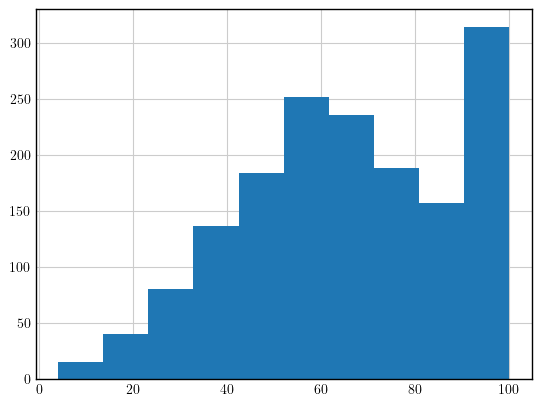

In [23]:
scores_preds.bleu_score.hist()

<Axes: >

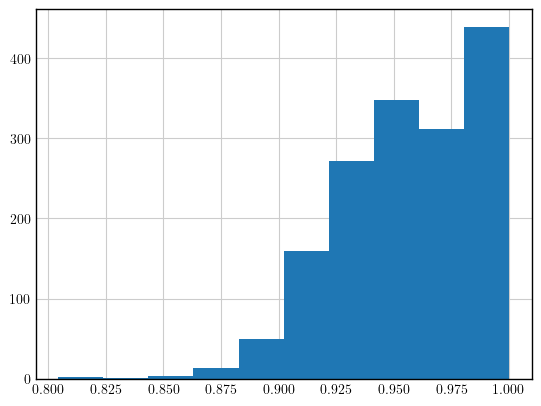

In [24]:
scores_preds.bert_f1.hist()

<Axes: >

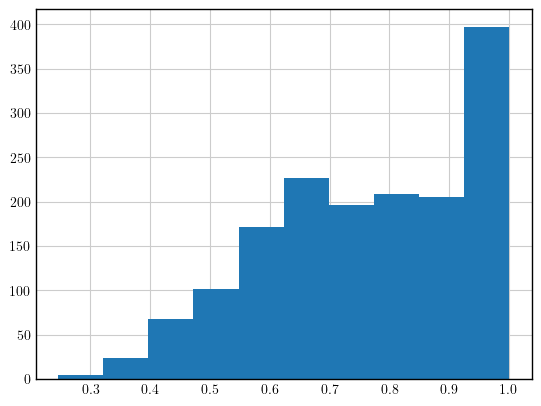

In [25]:
scores_preds.rouge_rougeL.hist()